# Syncing spike data with pycontrol

In [187]:
%reload_ext autoreload
%autoreload 2

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matplotlib.pylab as plt 
from tqdm.auto import tqdm
from trialexp.process.pyphotometry.utils import *
from trialexp.utils.ephys_utilities import create_sync_photo_ephys
import pandas as pd 
import xarray as xr
from trialexp.process.pycontrol import event_filters
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [81]:
base = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin')
path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/sorting')

In [307]:
# Manualliy find the correct timestamp file for now
rec_properties = pd.read_csv(path.parent/'rec_properties.csv')
rec_properties.sync_path.iloc[2]

# Manually get the start time for now
# TODO: fix the bug in create_folder
tstart = rec_properties.tstart.iloc[0]
tstart

626.1124

# Data sync

In [304]:
#load and create the sync object
# sync to photometry data for now, but later probably should sync everything back to pycontrol

photo_file = list((path.parents[1]/'pyphotometry').glob('*.ppd'))[0]
photo_data = import_ppd(photo_file)
photo_time = photo_data['pulse_times_2']
rsync = create_sync_photo_ephys(photo_time, path.parent/'correct')
assert rsync is not None

[ 626.23356667  626.23356667  626.23366667 ... 4225.24406667 4225.74413333
 4226.2442    ]


In [84]:
#load the spike extractor
probeA_sorting = si.load_extractor(path/'ProbeA')

In [308]:
# Sync and  all the sorting to ms
# spike time from sorting count from the beginning of the recording
# where the rsync time count from the beginning of the open ephys session
# so we need to shift the spike time to the ephys rsync time unit first

spike_times = []
Fs = 30000
max_time = 0
for id in tqdm(probeA_sorting.get_unit_ids()):
    spk_time = probeA_sorting.get_unit_spike_train(id)
    spk_time = (spk_time/Fs+tstart)*1000 #need to shift by the starting time of recording
    spk_time = rsync.A_to_B(spk_time)
    
    if len(spk_time)>0:
        max_time = max(max_time, spk_time[-1])
    spike_times.append(spk_time)

  0%|          | 0/962 [00:00<?, ?it/s]

In [309]:
# load xarray data and use that to bin the firing rate
xr_session = xr.load_dataset(path.parents[1]/'processed'/'xr_session.nc')

In [310]:
xr_session.time

<xarray.DataArray 'time' (time: 70629)>
array([  29621.5,   29671.5,   29721.5, ..., 3560921.5, 3560971.5, 3561021.5])
Coordinates:
  * time     (time) float64 2.962e+04 2.967e+04 ... 3.561e+06 3.561e+06

In [311]:
# convert spike timing to firing rate
# bin_size = 100
# bins = np.arange(0, np.ceil(max_time+bin_size), bin_size) #make sure we cover every bin

bin_size = 50
bins = np.append(xr_session.time.data, xr_session.time.data[-1]+50) # make sure we cover the whole range


spike_rates = np.zeros((len(bins)-1, len(spike_times)))

for i in tqdm(range(len(spike_times))):
    count, _ = np.histogram(spike_times[i], bins) 
    spike_rates[:,i] = count * (1000/bin_size)

  0%|          | 0/962 [00:00<?, ?it/s]

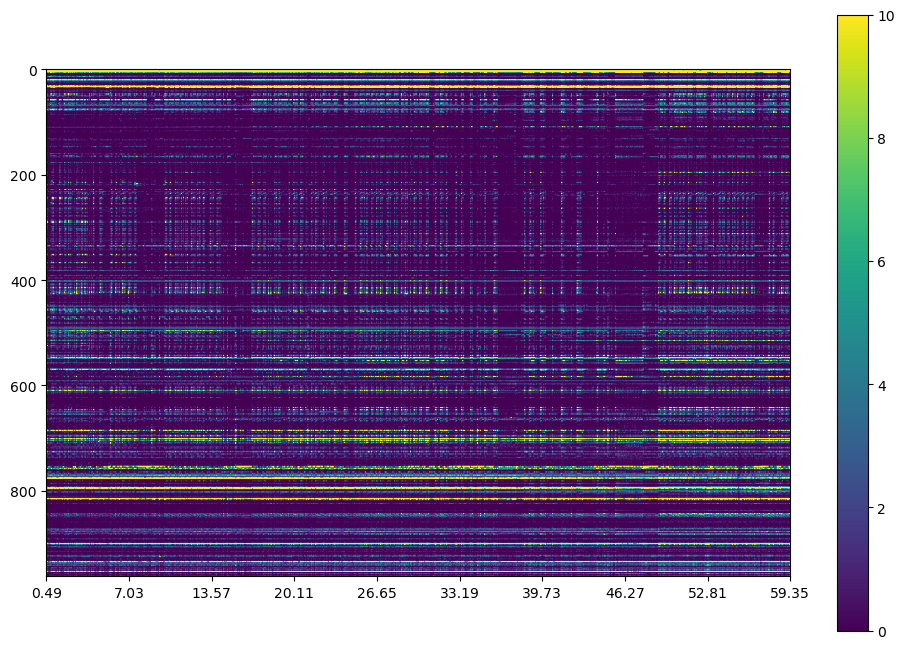

In [312]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.imshow(spike_rates.T, vmax=10)
plt.colorbar()
ax.set_aspect(50)
xticks = np.linspace(0,spike_rates.shape[0],10).astype(int)
ax.set_xticks(xticks);
labels = [f'{x:.2f}' for x in bins[xticks]/1000/60]
ax.set_xticklabels(labels);

In [313]:
cluster_ids = probeA_sorting.get_unit_ids()
xa_spike_rate = xr.DataArray(
    spike_rates, coords={'time':bins[:-1], 
                         'cluster_id':cluster_ids},
    dims=('time','cluster_id'))

# xa_spike_rate.expand_dims(dims={'probe':1})
xr_session['spike_rate'] = xa_spike_rate

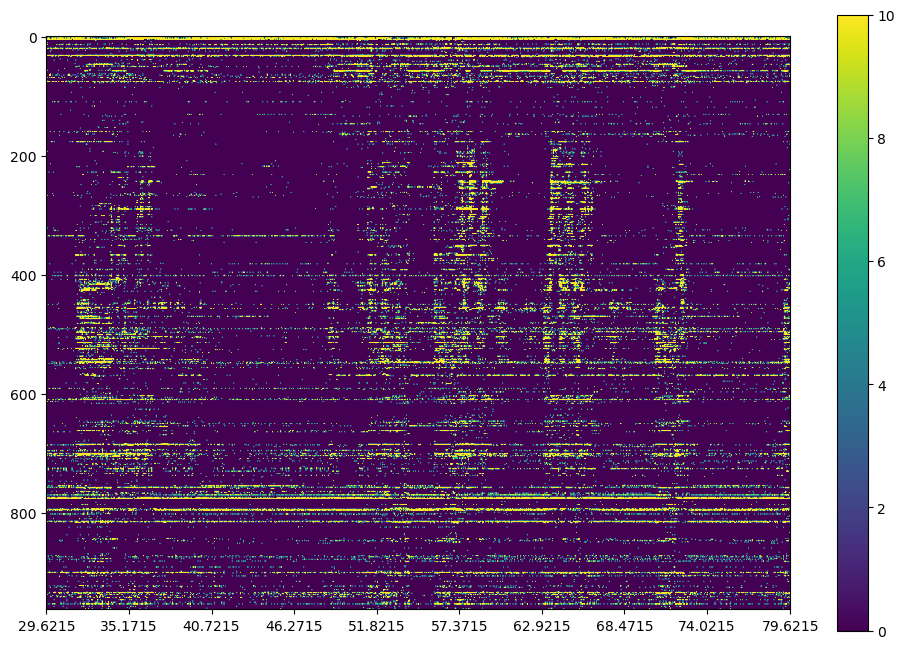

In [314]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.imshow(xr_session['spike_rate'].data.T, vmax=10)
plt.colorbar()
ax.set_xlim([0,1000])
ax.set_aspect(0.8)
xticks = np.linspace(0,1000,10).astype(int)
ax.set_xticks(xticks);
ax.set_xticklabels(xr_session.time.data[xticks]/1000);

<Axes: >

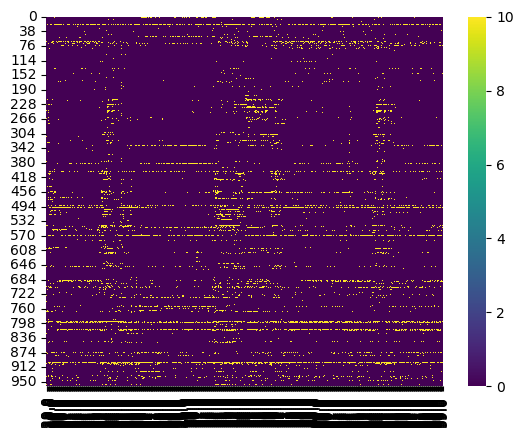

In [262]:
sns.heatmap(xr_session['spike_rate'].data.T[:,:600], vmax=10, cmap='viridis',
           xticklabels=xr_session.time.data[:600]//1000)

## Align spike data to events

In [315]:
df_pycontrol = pd.read_pickle(path.parents[1]/'processed'/'df_pycontrol.pkl')
rsync_time = df_pycontrol[df_pycontrol.name=='rsync'].time
pyphoto_aligner = Rsync_aligner(pulse_times_A= rsync_time, 
                pulse_times_B= photo_time, plot=False) #align pycontrol time to pyphotometry time


In [316]:
df_event = pd.read_pickle(path.parents[1]/'processed'/'df_events_cond.pkl')
trial_window = df_event.attrs['trial_window']
dataset = xr_session.copy()

In [317]:
trigger = df_event.attrs['triggers'][0]
event_time_coord = dataset.event_time
sampling_rate = dataset.attrs['sampling_rate']/bin_size #the data has already been downsampled
add_event_data(df_event, event_filters.get_first_event_from_name,
               trial_window, pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', trigger, sampling_rate,
               filter_func_kwargs={'evt_name':trigger}, 
               time_tolerance=bin_size, 
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 962)


In [318]:
add_event_data(df_event, event_filters.get_first_bar_off, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_bar_off', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 962)


In [319]:
add_event_data(df_event, event_filters.get_first_spout, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_spout', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 962)


In [320]:
dataset

<xarray.Dataset>
Dimensions:                            (session_id: 1, trial_nb: 161,
                                        time: 70629, event_time: 120,
                                        cluster_id: 962)
Coordinates:
  * session_id                         (session_id) object 'kms058-2023-03-23...
  * trial_nb                           (trial_nb) float64 1.0 2.0 ... 161.0
  * time                               (time) float64 2.962e+04 ... 3.561e+06
  * event_time                         (event_time) float64 -1.975e+03 ... 3....
  * cluster_id                         (cluster_id) int64 0 1 2 ... 959 960 961
Data variables: (12/30)
    uid                                (session_id, trial_nb) object 'kms058_...
    trigger                            (session_id, trial_nb) object 'hold_fo...
    valid                              (session_id, trial_nb) bool True ... True
    break_after_abort                  (session_id, trial_nb) bool False ... ...
    US_end_timer                       (session_id, trial_nb) bool False ... ...
    water_on                           (session_id, trial_nb) bool False ... ...
    ...                                 ...
    first_bar_off_analog_1_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_analog_1_df_over_f     (session_id, trial_nb, event_time) float64 ...
    spike_rate                         (time, cluster_id) float64 20.0 ... 0.0
    hold_for_water_spike_rate          (trial_nb, event_time, cluster_id) float64 ...
    first_bar_off_spike_rate           (trial_nb, event_time, cluster_id) float64 ...
    first_spout_spike_rate             (trial_nb, event_time, cluster_id) float64 ...
Attributes: (12/24)
    pulse_inds_1:         []
    pulse_inds_2:         [  14530   15689   19000   27812   32279   41272   ...
    pulse_times_1:        []
    pulse_times_2:        [  14530.   15689.   19000.   27812.   32279.   412...
    subject_ID:           kms058
    date_time:            2023-03-23T19:17:25
    ...                   ...
    Start date:           2023/03/23 19:17:40
    session_id:           kms058-2023-03-23-191740
    trial_window:         [-2000  4000]
    conditions:           ['break_after_abort', 'US_end_timer', 'water_on', '...
    triggers:             hold_for_water
    events_to_process:    ['bar', 'bar_off', 'spout', 'US_end_timer']

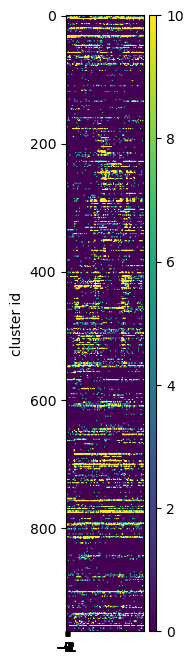

In [322]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
# extent=[120, 240, 0, 962]

def plot_spike_rate(x, aspect, xticks, yticks, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='10%', pad=0.05)
    im = ax.imshow(x, vmax=10)

    # plt.colorbar()
    ax.set(ylabel='cluster id')
    
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    # ax.set_aspect(aspect)
    ax.set_xticks(xticks)


plot_spike_rate(dataset['first_spout_spike_rate'].data[3].T, 0.5, 
                xticks=(dataset.event_time.data//1000), yticks=dataset.cluster_id,ax=ax)

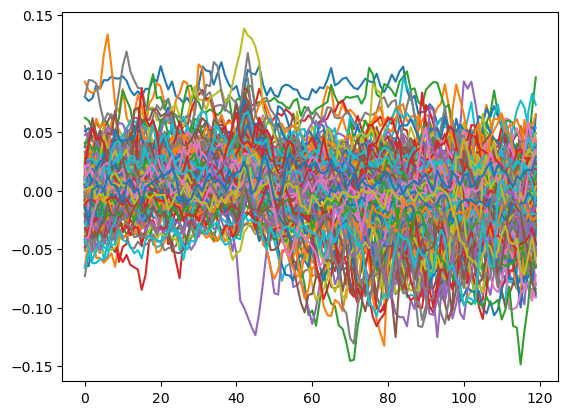

In [222]:
plt.plot(dataset['hold_for_water_analog_1_df_over_f'].data[0,:,:].T);

In [248]:
x = np.nanmean(dataset['first_spout_spike_rate'].data,axis=0)

<Axes: >

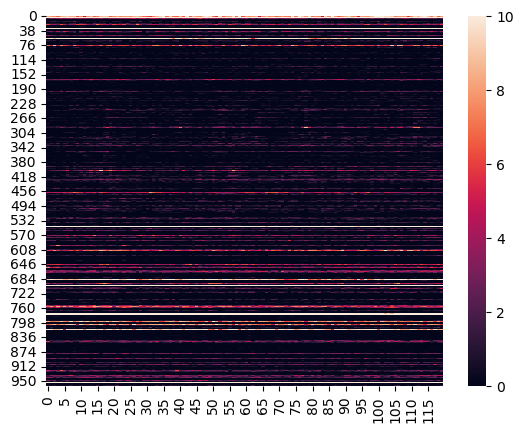

In [249]:
sns.heatmap(x.T,vmax=10)